# 🦛 Chonkie: An example of RecursiveChunker for PDF/Markdown Chunking

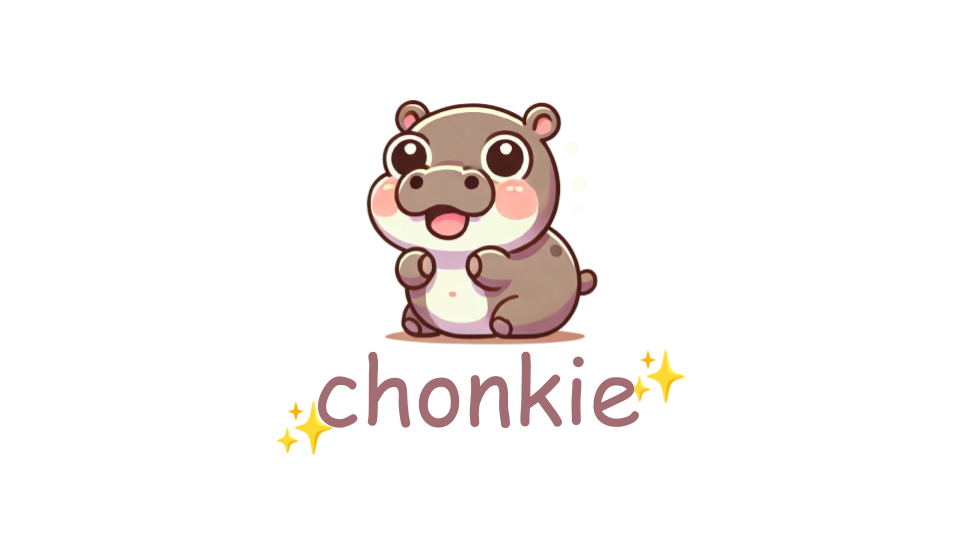

This notebook is meant to show how you can quickly parse, chunk, and RAG on arxiv papers yourself!

We use some awesome open-source repositories in this notebook. The stack that this notebook uses is the following:

- Chonkie (of course)
- Docling (for PDF conversion)
- Model2Vec (for embeddings)
- Vicinity (for indexing)
- Together Client (for LLM calls)

## Installs, Imports, Inits and Utils

Installation takes a looooooong time, but only the first time you try to install. You may even be required to hit restart on your colab notebook. Don't worry, that's completely normal! Go ahead, grab a cup of coffee and await the CHONK!

In [ ]:
!pip install -q chonkie docling model2vec vicinity together rich[jupyter]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.

In [ ]:
# Get all the required imports here
import os
from typing import List

from docling.document_converter import DocumentConverter
from google.colab import userdata
from model2vec import StaticModel
from rich.console import Console
from rich.text import Text
from together import Together
from transformers import AutoTokenizer
from vicinity import Backend, Metric, Vicinity

from chonkie import RecursiveChunker, RecursiveLevel, RecursiveRules

In [ ]:
# Initialize the rich text console for better printing
console = Console()

# Set your Together API key to use Deepseek R1 with it~
os.environ['TOGETHER_API_KEY'] = userdata.get('TOGETHER_API_KEY')

# Initialise a Document Converter
converter = DocumentConverter()

# This chunker would recursively split the text to get 256 tokens or less per chunk
rules = RecursiveRules(
    levels=[
        RecursiveLevel(delimiters=['######', '#####', '####', '###', '##', '#']),
        RecursiveLevel(delimiters=['\n\n', '\n', '\r\n', '\r']),
        RecursiveLevel(delimiters='.?!;:'),
        RecursiveLevel()
    ]
)
chunker = RecursiveChunker(rules=rules, chunk_size=384)

# Initialise a model2vec model for encoding sentences for retrieval
model = StaticModel.from_pretrained("minishlab/potion-retrieval-32M")

# Initialise the Together client to call upon Deepseek R1
client = Together()

# (Optional) Initialise the tokenizer for Deepseek R1
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/129M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/16.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.85M [00:00<?, ?B/s]

In [ ]:
# A wrapped up print function
def rprint(text: str, console: Console=console, width: int = 80) -> None:
  richtext = Text(text)
  console.print(richtext.wrap(console, width=width))

In [ ]:
# A simple utility function to make the prompts from the given chunks
def create_prompt(chunks: List[str], query: str) -> str:
  prompt_template = """<instructions>
  Based on the provided contexts, answer the given question to the best of your ability. Remember to also add citations at appropriate points in the format of square brackets like [1][2][3], especially at sentence or paragraph endings.
  You will be given 4 passages in the context, marked with a label 'Doc [1]:' to denote the passage number. Use that number for citations. Answer only from the given context, and if there's no appropriate context, reply "No relevant context found!".
  </instructions>

  <context>
  {context}
  </context>

  <query>
  {query}
  </query>
  """
  context = "\n\n".join([f"Doc {i+1}: {chunk}" for i, chunk in enumerate(chunks)])
  prompt = prompt_template.format(context=context, query=query)
  return prompt

## Step 1: Use docling to convert PDF -> Markdown!

This step takes about 20-30 seconds depending on your PDF.

In [ ]:
# Given a source PDF link, we can convert it to Markdown which is easier to use!
source = "https://arxiv.org/pdf/1706.03762"
result = converter.convert(source)
text = result.document.export_to_markdown()

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [ ]:
# Lets have a quick look at the text we'll be working with~
rprint(text[:2000])

Provided proper attribution is provided, Google hereby grants permission to 
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.

## Attention Is All You Need

Ashish Vaswani ∗ Google Brain avaswani@google.com

Noam Shazeer ∗ Google Brain noam@google.com

Niki Parmar ∗ Google Research nikip@google.com

Jakob Uszkoreit ∗ Google Research usz@google.com

Llion Jones ∗ Google Research llion@google.com

Aidan N. Gomez ∗ † University of Toronto

aidan@cs.toronto.edu

Łukasz Kaiser Google Brain lukaszkaiser@google.com

∗

Illia Polosukhin ∗ ‡

illia.polosukhin@gmail.com

## Abstract

The dominant sequence transduction models are based on complex recurrent or 
convolutional neural networks that include an encoder and a decoder. The best 
performing models also connect the encoder and decoder through an attention 
mechanism. We propose a new simple network architecture, the Transformer, based 
solely on attention mechanisms, dispensing with recurrence and convolutions 
entirely. Experiments on two machine translation tasks show these models to be 
superior in quality while being more parallelizable and requiring significantly 
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 
Englishto-German translation task, improving over the existing best results, 
including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French 
translation task, our model establishes a new single-model state-of-the-art BLEU
score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the
training costs of the best models from the literature. We show that the 
Transformer generalizes well to other tasks by applying it successfully to 
English constituency parsing both with large and limited training data.

## 1 Introduction

Recurrent neural networks, long short-term memory [13] and gated recurrent [7] 
neural networks in particular, have been firmly established as state of the art 
approaches in sequence modeling and transduction prob

In [ ]:
# Get the total deepseek tokens for the entire PDF
total_text_tokens = len(tokenizer.encode(text))
rprint(f"This PDF contains: {total_text_tokens} tokens")

This PDF contains: 9928 tokens

## Step 2: Chunk your texts w/ Chonkie!

In [ ]:
# This is all it takes to chunk!
chunks = chunker(text)
print(f"Total number of chunks: {len(chunks)}")

Total number of chunks: 58


In [ ]:
# Let's have a quick look at our chunks
for chunk in chunks[:4]:
  rprint(chunk.text)
  print('-'*80, '\n\n')

Provided proper attribution is provided, Google hereby grants permission to 
reproduce the tables and figures in this paper solely for use in journalistic or
scholarly works.

## Attention Is All You Need

Ashish Vaswani ∗ Google Brain avaswani@google.com

Noam Shazeer ∗ Google Brain noam@google.com

Niki Parmar ∗ Google Research nikip@google.com

Jakob Uszkoreit ∗ Google Research usz@google.com

Llion Jones ∗ Google Research llion@google.com

Aidan N. Gomez ∗ † University of Toronto

aidan@cs.toronto.edu

Łukasz Kaiser Google Brain lukaszkaiser@google.com

∗

Illia Polosukhin ∗ ‡

illia.polosukhin@gmail.com

##

-------------------------------------------------------------------------------- 




Abstract

The dominant sequence transduction models are based on complex recurrent or 
convolutional neural networks that include an encoder and a decoder. The best 
performing models also connect the encoder and decoder through an attention 
mechanism. We propose a new simple network architecture, the Transformer, based 
solely on attention mechanisms, dispensing with recurrence and convolutions 
entirely. Experiments on two machine translation tasks show these models to be 
superior in quality while being more parallelizable and requiring significantly 
less time to train. Our model achieves 28.4 BLEU on the WMT 2014 
Englishto-German translation task, improving over the existing best results, 
including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French 
translation task, our model establishes a new single-model state-of-the-art BLEU
score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the
training costs of the best models from the literature. We show that the 
Transformer generalizes well to other tasks by applying it successfully to 
English constituency parsing both with large and limited training data.

##

-------------------------------------------------------------------------------- 




1 Introduction

Recurrent neural networks, long short-term memory [13] and gated recurrent [7] 
neural networks in particular, have been firmly established as state of the art 
approaches in sequence modeling and transduction problems such as language 
modeling and machine translation [35, 2, 5]. Numerous efforts have since 
continued to push the boundaries of recurrent language models and 
encoder-decoder architectures [38, 24, 15].

Recurrent models typically factor computation along the symbol positions of the 
input and output sequences. Aligning the positions to steps in computation time,
they generate a sequence of hidden states h t , as a function of the previous 
hidden state h t -1 and the input for position t . This inherently sequential 
nature precludes parallelization within training examples, which becomes 
critical at longer sequence lengths, as memory constraints limit batching across
examples. Recent work has achieved significant improvements in computational 
efficiency through factorization tricks [21] and conditional computation [32], 
while also improving model performance in case of the latter. The fundamental 
constraint of sequential computation, however, remains.

Attention mechanisms have become an integral part of compelling sequence 
modeling and transduction models in various tasks, allowing modeling of 
dependencies without regard to their distance in the input or output sequences 
[2, 19]. In all but a few cases [27], however, such attention mechanisms are 
used in conjunction with a recurrent network.

In this work we propose the Transformer, a model architecture eschewing 
recurrence and instead relying entirely on an attention mechanism to draw global
dependencies between input and output. The Transformer allows for significantly 
more parallelization and can reach a new state of the art in translation quality
after being trained for as little as twelve hours on eight P100 GPUs.

##

-------------------------------------------------------------------------------- 




2 Background

The goal of reducing sequential computation also forms the foundation of the 
Extended Neural GPU [16], ByteNet [18] and ConvS2S [9], all of which use 
convolutional neural networks as basic building block, computing hidden 
representations in parallel for all input and output positions. In these models,
the number of operations required to relate signals from two arbitrary input or 
output positions grows in the distance between positions, linearly for ConvS2S 
and logarithmically for ByteNet. This makes it more difficult to learn 
dependencies between distant positions [12]. In the Transformer this is reduced 
to a constant number of operations, albeit at the cost of reduced effective 
resolution due to averaging attention-weighted positions, an effect we 
counteract with Multi-Head Attention as described in section 3.2.

Self-attention, sometimes called intra-attention is an attention mechanism 
relating different positions of a single sequence in order to compute a 
representation of the sequence. Self-attention has been used successfully in a 
variety of tasks including reading comprehension, abstractive summarization, 
textual entailment and learning task-independent sentence representations [4, 
27, 28, 22].

End-to-end memory networks are based on a recurrent attention mechanism instead 
of sequencealigned recurrence and have been shown to perform well on 
simple-language question answering and language modeling tasks [34].

To the best of our knowledge, however, the Transformer is the first transduction
model relying entirely on self-attention to compute representations of its input
and output without using sequencealigned RNNs or convolution. In the following 
sections, we will describe the Transformer, motivate self-attention and discuss 
its advantages over models such as [17, 18] and [9].

##

-------------------------------------------------------------------------------- 




## Step 3: Retrieval

### Step 3.1: Get the embeddings for each of the chunks!

In [ ]:
# Create some dummy data as strings or other serializable objects
items = [chunk.text for chunk in chunks]
vectors = model.encode(items)
print(vectors.shape)

(58, 512)


### Step 3.2: Create an index with the chunks and embeddings for retrieval

In [ ]:
# Initialize the Vicinity instance (using the basic backend and cosine metric)
vicinity = Vicinity.from_vectors_and_items(
    vectors=vectors,
    items=items,
    backend_type=Backend.BASIC,
    metric=Metric.COSINE
)

### Step 3.3: Get results for a given query from the index~

In [ ]:
# Set a query that you wish to answer, and get it's embeddings
query = "What is a Multi-Head Self Attention?"

In [ ]:
# Encode the query and get the top 4 chunks
query_vector = model.encode(query)

# Query for nearest neighbors with a top-k search
results = vicinity.query(query_vector, k=4)

In [ ]:
# Let's have a look at the retrieved chunks
retrieved_chunks = [x[0] for x in results[0]]

for chunk in retrieved_chunks:
  rprint(chunk)
  print('-'*80, '\n\n')

Attention Visualizations Input-Input Layer5

Figure 3: An example of the attention mechanism following long-distance 
dependencies in the encoder self-attention in layer 5 of 6. Many of the 
attention heads attend to a distant dependency of the verb 'making', completing 
the phrase 'making...more difficult'. Attentions here shown only for the word 
'making'. Different colors represent different heads. Best viewed in color.

<!-- image -->

Input-Input Layer5

Figure 4: Two attention heads, also in layer 5 of 6, apparently involved in 
anaphora resolution. Top: Full attentions for head 5. Bottom: Isolated 
attentions from just the word 'its' for attention heads 5 and 6. Note that the 
attentions are very sharp for this word.

<!-- image -->

Input-Input Layer5

Figure 5: Many of the attention heads exhibit behaviour that seems related to 
the structure of the sentence. We give two such examples above, from two 
different heads from the encoder self-attention at layer 5 of 6. The heads 
clearly learned to perform different tasks.

<!-- image -->

-------------------------------------------------------------------------------- 




2 Background

The goal of reducing sequential computation also forms the foundation of the 
Extended Neural GPU [16], ByteNet [18] and ConvS2S [9], all of which use 
convolutional neural networks as basic building block, computing hidden 
representations in parallel for all input and output positions. In these models,
the number of operations required to relate signals from two arbitrary input or 
output positions grows in the distance between positions, linearly for ConvS2S 
and logarithmically for ByteNet. This makes it more difficult to learn 
dependencies between distant positions [12]. In the Transformer this is reduced 
to a constant number of operations, albeit at the cost of reduced effective 
resolution due to averaging attention-weighted positions, an effect we 
counteract with Multi-Head Attention as described in section 3.2.

Self-attention, sometimes called intra-attention is an attention mechanism 
relating different positions of a single sequence in order to compute a 
representation of the sequence. Self-attention has been used successfully in a 
variety of tasks including reading comprehension, abstractive summarization, 
textual entailment and learning task-independent sentence representations [4, 
27, 28, 22].

End-to-end memory networks are based on a recurrent attention mechanism instead 
of sequencealigned recurrence and have been shown to perform well on 
simple-language question answering and language modeling tasks [34].

To the best of our knowledge, however, the Transformer is the first transduction
model relying entirely on self-attention to compute representations of its input
and output without using sequencealigned RNNs or convolution. In the following 
sections, we will describe the Transformer, motivate self-attention and discuss 
its advantages over models such as [17, 18] and [9].

##

-------------------------------------------------------------------------------- 




Scaled Dot-Product Attention

<!-- image -->

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention 
consists of several attention layers running in parallel.

<!-- image -->

of the values, where the weight assigned to each value is computed by a 
compatibility function of the query with the corresponding key.

##

-------------------------------------------------------------------------------- 




3.2.2 Multi-Head Attention

Instead of performing a single attention function with d model-dimensional keys,
values and queries, we found it beneficial to linearly project the queries, keys
and values h times with different, learned linear projections to d k , d k and d
v dimensions, respectively. On each of these projected versions of queries, keys
and values we then perform the attention function in parallel, yielding d v 
-dimensional

output values. These are concatenated and once again projected, resulting in the
final values, as depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from 
different representation subspaces at different positions. With a single 
attention head, averaging inhibits this.

$$MultiHead( Q,K,V ) = Concat(head 1 , ..., head h ) W O where head = Attention(
QW Q , KW K , V W V )$$

$$i i i i$$

Where the projections are parameter matrices W Q i ∈ R d model × d k , W K i ∈ R
d model × d k , W V i ∈ R d model × d v and W O ∈ R hd v × d model .

In this work we employ h = 8 parallel attention layers, or heads. For each of 
these we use d k = d v = d model /h = 64 . Due to the reduced dimension of each 
head, the total computational cost is similar to that of single-head attention 
with full dimensionality.

##

-------------------------------------------------------------------------------- 




## Step 4: Generate an answer with the LLM

In [ ]:
# Let's generate the prompt to use~
prompt = create_prompt(retrieved_chunks, query)
prompt_tokens = len(tokenizer.encode(prompt))
rprint(f"This prompt contains: {prompt_tokens} tokens")

This prompt contains: 1102 tokens

In [ ]:
# And finally the respose~
response = client.chat.completions.create(
    model="deepseek-ai/DeepSeek-R1",
    messages=[{"role": "user", "content": prompt}],
)

In [ ]:
# Print the final response without the thinking tokens
answer = response.choices[0].message.content.split("</think>")[-1]
rprint(answer)

Multi-Head Self Attention is a mechanism in the Transformer architecture that 
enables the model to jointly process information from different representation 
subspaces at different positions within a sequence. Instead of performing a 
single attention function, it linearly projects the input's queries, keys, and 
values multiple times into lower-dimensional subspaces using distinct learned 
projections. Each projection (or "head") independently performs scaled 
dot-product self-attention, which involves relating different positions of the 
input sequence to compute a contextual representation [2][4]. 

The outputs from all heads are concatenated and linearly transformed to produce 
the final result. This design allows the model to capture diverse dependencies, 
such as long-range relationships or syntactic patterns, more effectively than 
single-head attention. For example, different heads may specialize in tasks like
resolving anaphora or tracking verb phrases [1]. The computational efficiency is
maintained by reducing the dimensionality of each head (e.g., using 8 heads with
64 dimensions each in the original Transformer) while preserving the total 
parameter count [4].

## Conclusions

We got a great answer back from Deepseek R1, while saving about **~8,800 input tokens** to Deepseek!

Hope you liked the notebook~ If you find chonkie useful for your applications and need some support with it, reach out at `support@chonkie.ai` or over the Discord server.

# Fin.